# <center>Modeling Newsletter Subscription</center>


## **<ins>Introduction</ins>**

In the gaming industry, understanding player behavior is crucial for designing engagement strategies and improving retention. One common strategy used by game developers is promoting in-game newsletters, which keep players informed about updates, events, and promotions. These newsletters are typically opt-in, meaning players choose whether or not to subscribe. Understanding what kinds of players are more likely to subscribe can help developers better target their communication efforts.

In this project, we aim to explore the question:
**Can a player's playtime and age predict whether they subscribe to the game-related newsletter in <ins>players.csv</ins>?**

By identifying potential patterns in subscription behavior based on quantitative characteristics, this analysis can offer insight into which types of players are more engaged or committed to the game.

To explore this question, we used a dataset titled <ins>players.csv</ins>, which contains information on 196 individuals who play the game. This dataset includes 7 variables:

### <ins>players.csv</ins> Dataset


| Variable               | Type                | Description  |
|------------------------|---------------------|--------------|
| **experience**         |<chr\>| Player's level of in-game experience.|
| **subscribe**          |<lgl\>| Indicates if player is subscribed to in-game newsletters.|
| **hashedEmail**        |<chr\>| Player's anonymous email.|
| **played_hours**       |<dbl\>| Time playing session started (relative).|
| **name**               |<chr\>| Player's in-game name.|
| **gender**             |<chr\>| Player's gender.|
| **Age**                |<dbl\>| Player's age.|


While most variables are not directly relevant to this project, we focus on the numeric variables ```played_hours``` and ```Age``` as predictors, and ```subscribe``` as the response variable. It's worth noting that the dataset contains some outliers in ```played_hours```, but we chose to keep them because they may represent highly engaged players whose behavior is important for predicting newsletter subscription patterns.

## **<ins>Methods & Results</ins>**


In [16]:
### Run this cell for initialization of packages
library(tidyverse)
library(tidymodels)
library(cowplot)
library(repr)
library(RColorBrewer)
library(gridExtra)
options(repr.matrix.max.rows = 6)
set.seed(4)

### Wrangling Data Into a Tidy Format

The <ins>players.csv</ins> and <ins>sessions.csv</ins> dataset is already tidy. Therefore, there is no need for additional wrangling. However, we combined the two files to have a single data frame with the most information for further analysis after modelling. From the session's data, we counted the number of sessions each player had based on their hashed email, then added that data to the players_data data frame through left_join. In doing so, players with no sessions had NA values under the number_sessions column, and therefore, we replaced those values with zero for vector analysis. In addition, we converted the experience column from characters to a numeric scale from 1-5 as a part of our planned data analysis.

In [15]:
set.seed(5)

# Set url's from github repository
players_url <- "https://raw.githubusercontent.com/Alonso181006/Individual-Project/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/Alonso181006/Individual-Project/refs/heads/main/sessions.csv"

# Read the data from the url's
players_data <- read_csv(players_url)
sessions_data <- read_csv(sessions_url)

# Count number of sessions for each user
sessions_data_count <- sessions_data |>
    group_by(hashedEmail) |>
    summarize(number_sessions = n())

# Renamed column
session_data_tidy <- sessions_data_count |>
    rename(hashed_email = hashedEmail)

# Combine Two Data Frames
players_data_combine <- players_data |>
    left_join(session_data_tidy, by = "hashed_email")

# Update Data Frame to replace NA values, and set subscribe column as a factor 
players_data_update <- players_data_combine |>
    mutate(number_sessions = replace_na(number_sessions, 0), 
          subscribe = as.factor(subscribe)) 

# Add a column that sets the experience level as a rank from 1-5 (inclusive)
players_data <- players_data_update|>
    mutate(rank = as.integer(factor(experience, 
                                    levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))))
# Display Data Set
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashed_email, name, gender
dbl (2): played_hours, age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro        TRUE     
2   Veteran    TRUE     
3   Veteran    FALSE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro        TRUE     
    hashed_email                                                    
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            age number_sessions rank
1   30.3         Morgan    Male               9  27              5   
2    3.8         Christian Male              17   3              4   
3    0.0         Blake     Male              17   1              4   
⋮   ⋮            ⋮         ⋮                 ⋮   ⋮               ⋮   
194 0.0          Dylan     Prefer not to say 17  1               2   
195 2.3          Harlow    Male              17  6               2   
196 0.2          Ahmed     Other             NA  1               5

### Computing summary statistics all quantitative variables (```played_hours```, ```Age```) 

In [17]:
# storing the selected columns in a variable
players_selected <- select(players_data, played_hours, age)

# calculating the mean
players_mean <- players_selected |>
    map_df(mean, na.rm = TRUE) |>
    rename(mean_played_hours = played_hours, mean_age = age)

players_mean

# calculating the median
players_median <- players_selected |>
    map_df(median, na.rm = TRUE) |>
    rename(median_played_hours = played_hours, median_age = age)

# calculating the mode
players_mode <- players_selected |>
    map_df(mode) |>
    rename(mode_played_hours = played_hours, mode_age = age)

# calculating the Standard Deviation (SD)
players_sd <- players_selected |>
    map_df(sd, na.rm = TRUE) |>
    rename(sd_played_hours = played_hours, sd_age = age)

# calculating the min 
players_min <- players_selected |>
    map_df(min, na.rm = TRUE) |>
    rename(min_played_hours = played_hours, min_age = age)

# calculating the max
players_max <- players_selected |>
    map_df(max, na.rm = TRUE) |>
    rename(max_played_hours = played_hours, max_age = age)

# all summary statistics of played_hours and Age
summary_combined <- bind_cols(players_mean, players_median, players_mode, players_sd, players_max, players_min)
summary_combined

mean_played_hours mean_age
1 5.845918          20.52062

mean_played_hours mean_age median_played_hours median_age mode_played_hours
1 5.845918          20.52062 0.1                 19         numeric          
  mode_age sd_played_hours sd_age   max_played_hours max_age min_played_hours
1 numeric  28.35734        6.174667 223.1            50      0               
  min_age
1 8

### Visualization
In order to understand how our model might work, we created four different plots to understand the data better. In doing so, we will be able to acquire key insights for a choice of modelling, as well as how to explain inefficiencies in the model. We utilized a bar plot, two histograms, and a scatter plot, as they were key in showcasing how our quantitative variables of played_hours and age might vary and affect subscription rate. 

`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


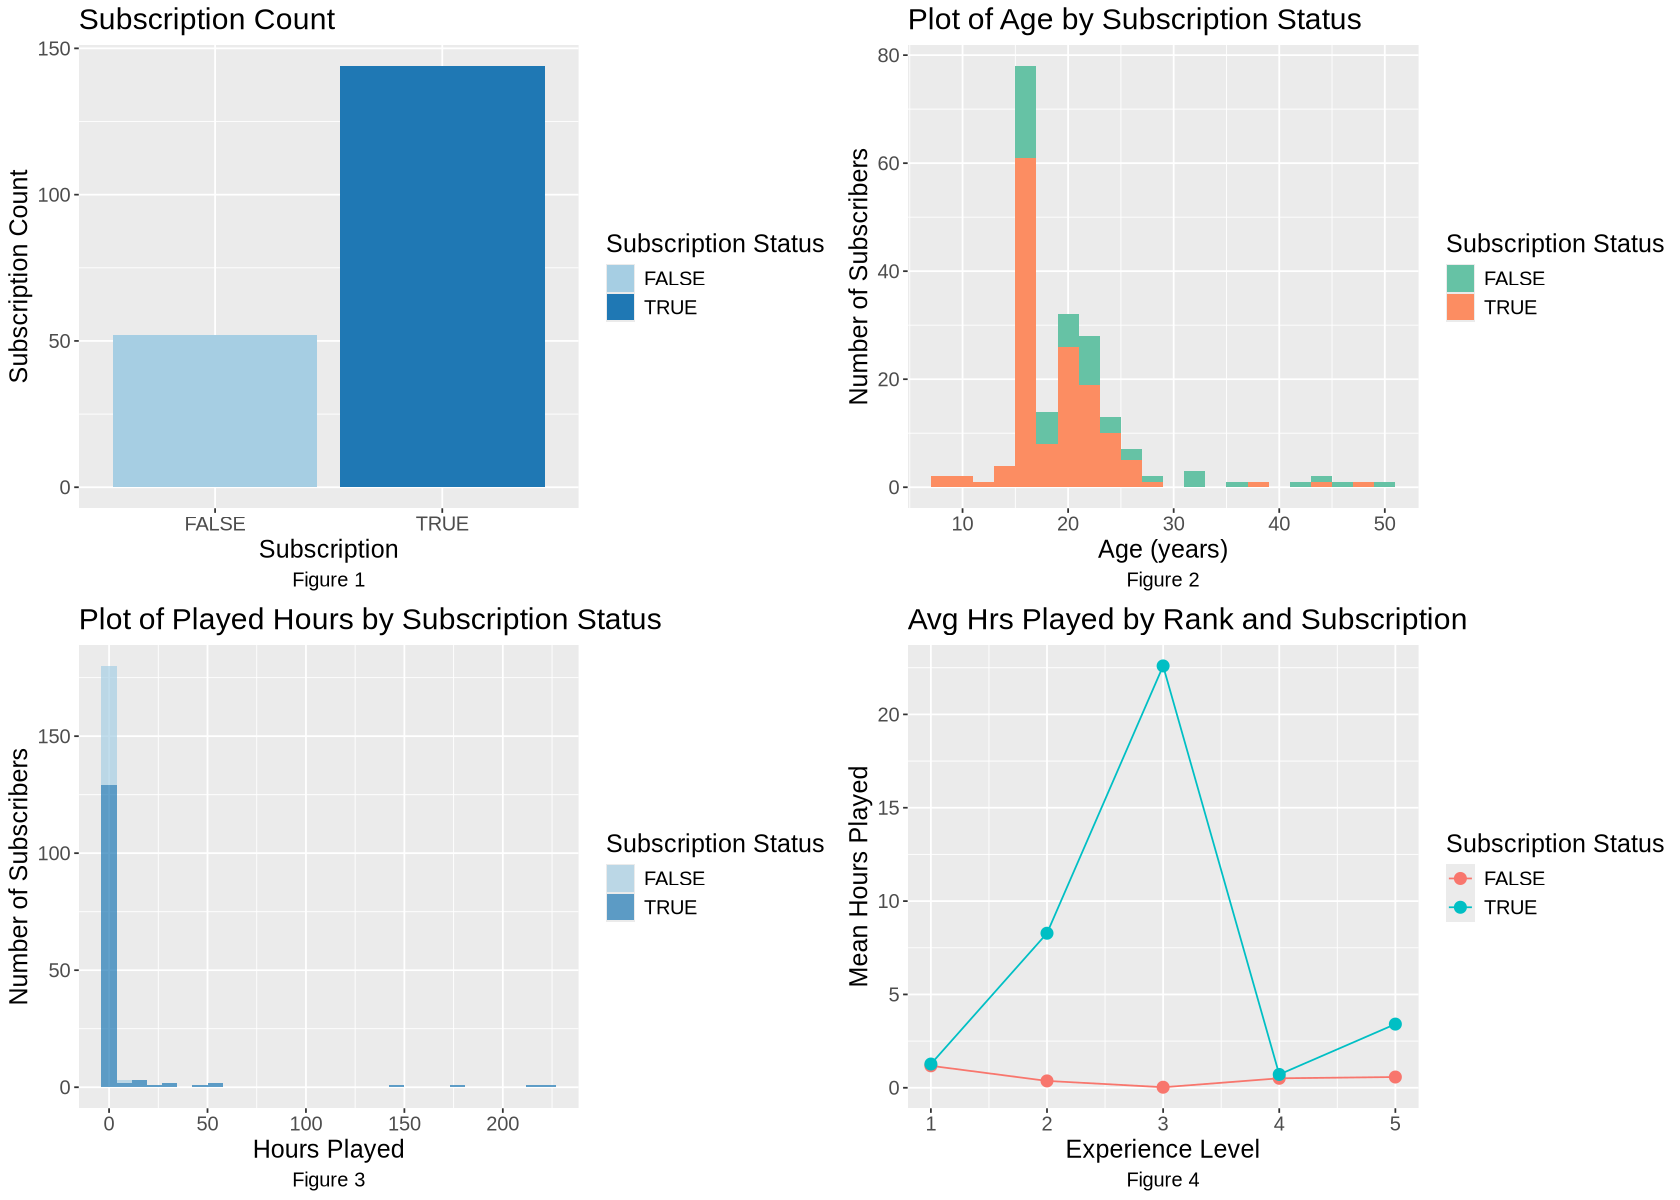

In [27]:
# Plot to Visualize Relationship between Subscribe & Played Hours, Experience, & Age

# Bar plot of subscription status counts
subsribe_bar <- players_data |>
    ggplot(aes(x = subscribe, fill = subscribe)) + 
    geom_bar() + 
    labs(x = "Subscription", 
         y = "Subscription Count", 
         fill = "Subscription Status",
         title = "Subscription Count",
         caption = "Figure 1") + 
    scale_fill_brewer(palette = "Paired") +
    theme(text = element_text(size = 15)) + 
    theme(plot.caption = element_text(hjust = 0.5)) 


# Histogram showing the distribution of age, colored by subscription status.
age_by_sub <- players_data |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age (years)", y = "Number of Subscribers", fill = "Subscription Status", caption = "Figure 2") +
    ggtitle("Plot of Age by Subscription Status") +
    theme(text = element_text(size = 15)) +
    scale_fill_brewer(palette = "Set2") + 
    theme(plot.caption = element_text(hjust = 0.5)) 

# Histogram showing the distribution of played hours, colored by subscription status.
subscription_plot <- players_data |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 30, alpha = 0.7) +
    labs(title = "Plot of Played Hours by Subscription Status", 
         x = "Hours Played", 
         y = "Number of Subscribers", 
         fill = "Subscription Status", 
         caption = "Figure 3") +
    theme(text = element_text(size = 15)) + 
    scale_fill_brewer(palette = "Paired") +
    theme(plot.caption = element_text(hjust = 0.5)) 


# Finding average played hours based on rank and subscription
players_data_avg_hours <- players_data |>
  group_by(rank, subscribe) |>
  summarise(mean_hours = mean(played_hours, na.rm = TRUE)) |>
  ungroup()

# Visualize average hours against experience level
players_plot_outliers <- players_data_avg_hours |>
    ggplot(aes(x = rank, y = mean_hours, color = subscribe)) +
    geom_line() +
    geom_point(size = 3) +
    labs(x = "Experience Level", 
         y = "Mean Hours Played", 
         color = "Subscription Status", 
         title = "Avg Hrs Played by Rank and Subscription", 
         caption = "Figure 4") +
    theme(text = element_text(size = 15)) + 
    theme(plot.caption = element_text(hjust = 0.5)) 

# Combine plots into 2x2 grid layout .
options(repr.plot.width = 14, repr.plot.height = 10)
plot_grid(subsribe_bar, age_by_sub, subscription_plot, players_plot_outliers, nrow = 2, ncol = 2)

### Visualization Insights: 
* Figure 1 shows that there are more subscribers vs non-subscribers
    * Roughly 50 or 25% of the observations are not subscribed
    * Riughly 150 or 75% of the observations are subscribed
* Figure 2 illustrates how subscriber count by age, indicating most subscribers are between 15-25 years old
    * Most players and subscribers were aged around 17
    * Players under 17 were 100% likely to be subscribed to the newsletter
    * Players after the age of 30 are more likley to not be subscribed to the newsletter
* Figure 3, demonstrates subscriber count by hours played, however most users have played less an hour
    * Players that have more than an hour played are highly likely to be subscribed
    * Players under an hour of play time are split roughly 70/30 in terms of subscription status
        * Thus other variables will have to be utilized to differentiate between players with low played time
* Figure 4 conveys how hours played differs based on experience level and subscription status.
    * It is important to note there are outliers in the data that skew the infographic.
    * However the evidence that higher hours played results in an increased subsciption rate is supported by Figure 3

### Data Analysis
K-NN classification will predict subscription status using played_hours and age as numeric predictors and subscribe as the categorical response variable. This method is appropriate because K-NN works with numeric inputs while predicting categorical outputs. Since the goal is to classify subscription status rather than predict a continuous value, K-NN classification is used instead of K-NN regression.

K-NN assumes closer data points are more similar, which makes sense since players with similar playtime and age likely have similar engagement. However, K-NN is sensitive to outliers, can overfit with small k values, and slows down with larger datasets. Standardizing the data ensures both predictors contribute equally to distance calculations.

The data has been split into 70% training and 30% testing. A 5-fold cross-validation will be used to fine-tune k, optimizing model performance while preventing overfitting. The training set will determine the best k, and the test set will evaluate the final accuracy. 

### Finding Optimal K Value ###
Our analysis consists of classification utilizing the k-nearest neighbour model. To proceed with the modelling, we have to find the most optimal k-value to train and fit our data to test the model's reliability eventually. To achieve this, we initially split the data into the training and testing sets, created the player recipe, and set the model's neighbour's parameter to tune() to test it for multiple neighbour values. We added the recipe and model to the workflow and then performed cross-validation using 5-folds for neighbours from 1-20 to prevent underfitting. From this evaluation of the training data, we found that 15 neighbours would be best, which is visualized in the plot below. 

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





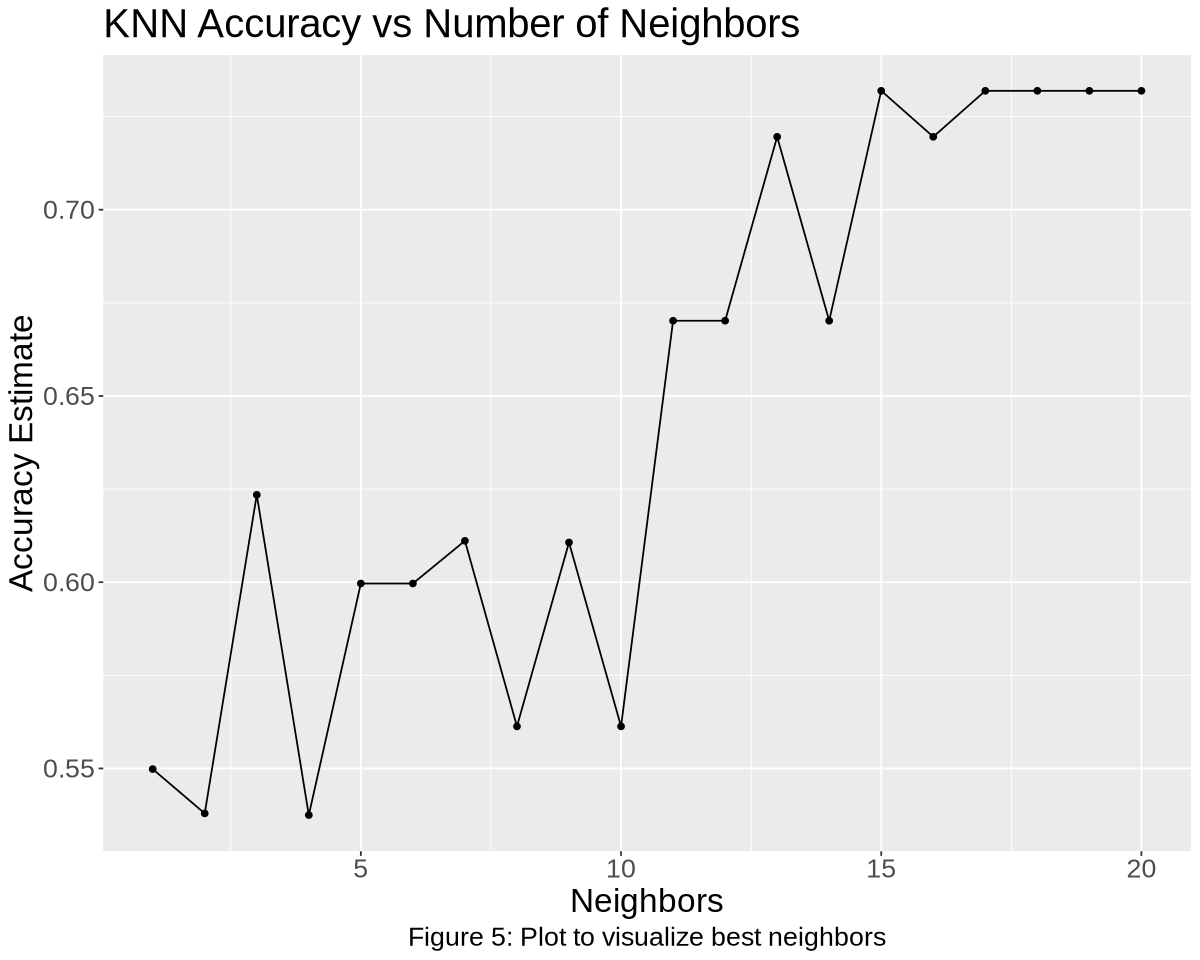

In [20]:
# Set seed to prevent different splits of data
set.seed(5)

# Split data into training and testing sets at 30/70 split
players_split <- initial_split(players_data, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# Create players recipe for Classification
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create player knn-model, tuning the neighbor value
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Perform cross-validation using 5-fold
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# Create a tibble of possible 'neighbors' values 1 to 10
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Setup workflow to test k values with cross-validation
players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals)

# Collect and Filter the metrics for evaluation.
players_results <- players_wkflw |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# Pull Best K value
best_k = players_results |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Plot the Accuracy vs Neighbors estimate
players_plot <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy vs Number of Neighbors", 
        caption = "Figure 5: Plot to visualize best neighbors") +
    theme(text = element_text(size = 20)) + 
    theme(plot.caption = element_text(hjust = 0.5)) 

#Display Plot
options(repr.plot.width = 10, repr.plot.height = 8)
players_plot

### Data Modeling

In [21]:
# Set seed 
set.seed(5)

# Re-create player model using the optimal k value
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification") 

# Fit the workflow to the player traing data
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

# Predict the subcription of players in test set
players_summary <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) 

# Compute & Display accuracy of the Knn Classfication on test dataset
players_accuracy <- players_summary |>
    metrics( truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_accuracy

# Compute & Display precision of the Knn Classfication on test dataset
players_precision <- players_summary |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")
players_precision

# Compute & Display recall of the Knn Classfication on test dataset
players_recall <- players_summary |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")
players_recall

# Compute & Display confusion matrix of the Knn Classfication on test dataset
players_matrix <- players_summary |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_matrix

.metric  .estimator .estimate
1 accuracy binary     0.7666667

.metric   .estimator .estimate
1 precision binary     0.7586207

.metric .estimator .estimate
1 recall  binary     1

          Truth
Prediction FALSE TRUE
     FALSE     2    0
     TRUE     14   44

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


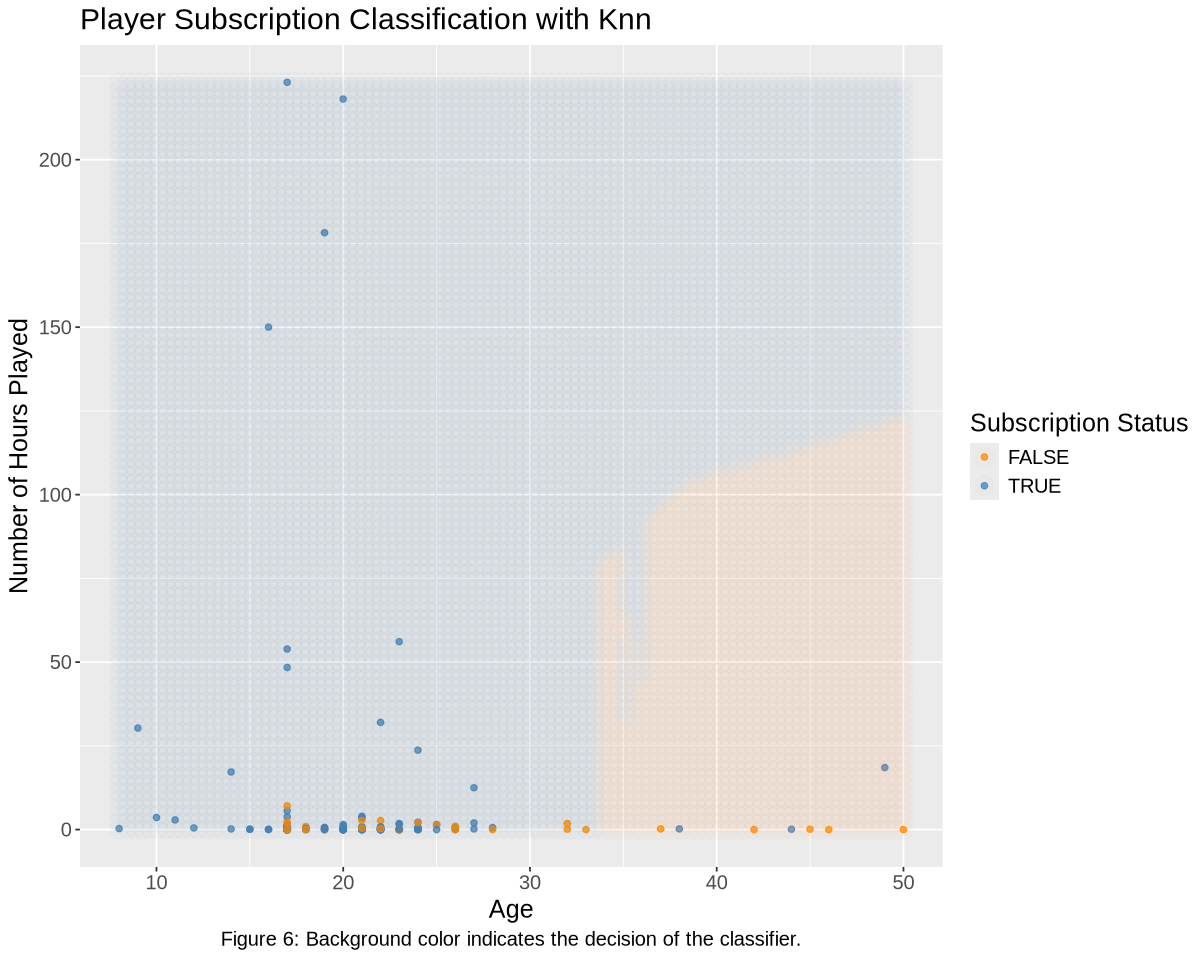

In [13]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(8,
                50,
                length.out = 100)
smo_grid <- seq(min(players_data$played_hours),
                max(players_data$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(age = are_grid,
                                played_hours = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(players_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(subscribe = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
    ggplot() +
    geom_point(data = players_data,
                mapping = aes(x = age,
                            y = played_hours,
                            color = subscribe),
                alpha = 0.75) +
    geom_point(data = prediction_table,
                mapping = aes(x = age,
                            y = played_hours,
                            color = subscribe),
                alpha = 0.02,
                size = 5) +
    labs(color = "Subscription Status",
        x = "Age",
        y = "Number of Hours Played", 
        title = "Player Subscription Classification with Knn",
        caption = "Figure 6: Background color indicates the decision of the classifier.") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15)) + 
  theme(plot.caption = element_text(hjust = 0.5)) 

wkflw_plot

## **<ins>Discussion</ins>**


The results of our analysis suggest that a player's playtime and age can predict newsletter subscription behaviour. Using a k-Nearest Neighbors model, the classification achieved an accuracy of 76.7%, a precision of 75.8% and a recall of 100%. All actual subscribers were correctly identified. However, 14 non-subscribers were misclassified, demonstrating that the model may sometimes tend to overpredict.

The findings are somewhat expected, as higher engagement often correlates with interest in in-game updates. This insight can help make marketing efforts more efficient by targeting regular gamers. Additionally, at a lower age, the importance surrounding what clutters your email inbox is less of a priority, and thus, students are more likely to provide their email for the newsletter that they might never read.

While the model is imperfect, it offers information that can be used to explore other unknowns. Knowing that age and playtime contribute to whether a person subscribes to a game-related newsletter, researchers can investigate whether age is a stronger predictor than playtime. In addition, the specific age range that is most likely to subscribe can be investigated. Future work could explore other predictors, test other models, or analyze behavioural patterns over time to better understand subscription behaviour. In terms of applications for our model, it can improve efficiency on targetting users due to a recall of 100% mitigating any false negatives, which would help reduce resources towards acquiring users that are guaranteed to never subscribe. 

## **<ins>References</ins>**

*Data Science, A First Introduction*
https://datasciencebook.ca/

*Data wrangling, exploration, and analysis with R*
https://stat545.com/join-cheatsheet.html 